In [1]:
import csv
import numpy as np
import math
import random
import matplotlib.pyplot as plt


In [2]:
def read_microdata(filename):
    # Open the file in read mode
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        first_line = next(reader)
        headers = first_line[1:]
        data_array = np.empty((0, len(headers)), dtype=float)
        micro_data_ids =[]
        # Iterate through each row in the CSV file
        for row in reader:
            # Process each row
            micro_data_ids.append(row[0])
            data_array = np.append(data_array, [np.array(row[1:], dtype=float)], axis=0)
    return {
        'headers':headers,
        'micro_data_ids':micro_data_ids,
        'data_array':data_array
    }

In [3]:
def read_constraints(filename):
    # Open the file in read mode
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        first_line = next(reader)
        headers = first_line[2:]
        data_array = np.empty((0, len(headers)), dtype=float)
        geo_data_ids =[]
        population_totals=[]
        # Iterate through each row in the CSV file
        for row in reader:
            # Process each row
            geo_data_ids.append(row[0])
            population_totals.append(row[1])
            data_array = np.append(data_array, [np.array(row[2:], dtype=float)], axis=0)
    return {
        'headers':headers,
        'geo_data_ids':geo_data_ids,
        'population_totals':population_totals,
        'data_array':data_array
    }

In [4]:
micro_data = read_microdata('testdata/microdata_encoded.csv')
constraint_data = read_constraints('testdata/constraint_targets.csv')
# micro_data = read_microdata('testdata/easy_encoded.csv')
# constraint_data = read_constraints('testdata/easy_targets.csv')

In [5]:
micro_data['headers'] == constraint_data['headers']


True

In [6]:
class SimulatedAnnealing:
    def __init__(self, sa_parameters, population_parameters):
        # Population parameters
        self.position = population_parameters['pos']  # Not currently used
        self.geo_id = population_parameters['geo_id']  # Not currently used
        self.population_size = population_parameters['population_size']/100.0
        self.constraints = population_parameters['constraints']
        self.constraint_weights = population_parameters['weights']
        self.micro_data = population_parameters['micro_data']
        
        # Problem dimensions
        self.micro_records, self.micro_features = self.micro_data.shape
        self.individual_weight = 1 / self.population_size

        # SA parameters
        self.current_temp = sa_parameters['initial_temp']
        self.initial_temp = sa_parameters['initial_temp']
        self.cooling_rate = sa_parameters['cooling_rate']
        self.min_temp = sa_parameters['min_temp']
        self.early_stop = sa_parameters['early_stop']
        self.steps_per_temp = sa_parameters['steps_per_temp']

        # Early stopping parameters
        self.patience = sa_parameters.get('patience', 20)  # Default 20 iterations
        self.min_energy_delta = sa_parameters.get('min_energy_delta', 1e-6)  # Minimum significant improvement        

        # Initialize population and macro data
        self.population = np.random.randint(self.micro_records, size=int(self.population_size))
        self.initialize_macro_data()
        self.start_macro_data = self.macro_data.copy()
        self.current_energy = self.calculate_weighted_kl_divergence(self.macro_data)

    def initialize_macro_data(self):
        """Calculate initial macro data aggregation"""
        self.macro_data = np.zeros(self.micro_features)
        for individual in self.population:
            self.macro_data += (self.micro_data[individual] * self.individual_weight)
       

    def calculate_chi_squared(self, test_data):
        """Calculate chi-squared distance between constraints and test data"""
        epsilon = 1e-10
        return np.sum((self.constraints - test_data) ** 2 / (self.constraints + epsilon))

    def calculate_weighted_kl_divergence(self, test_data):
        epsilon = 1e-10
        log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
        
        # Apply combined weights
        weighted_terms = self.constraint_weights * self.constraints * log_ratio
        
        return np.sum(weighted_terms)    

    def calculate_kl_divergence(self, test_data):
        """Calculate KL divergence between constraints and test data"""
        epsilon = 1e-10
        return np.sum(self.constraints * np.log((self.constraints + epsilon) / (test_data + epsilon)))

    def calculate_acceptance_probability(self, new_energy):
        """Determine probability of accepting worse solution"""
        if new_energy < self.current_energy:
            return 1.0
        return math.exp((self.current_energy - new_energy) / self.current_temp)

    def generate_neighbor_solution(self):
        """Generate a neighboring solution by modifying one individual"""
        # Select random individual to replace
        individual_idx = np.random.randint(self.population_size)
        old_micro_record = self.micro_data[self.population[individual_idx]]
        
        # Select new random individual from microdata
        new_micro_idx = np.random.randint(self.micro_records)
        new_micro_record = self.micro_data[new_micro_idx]

        # Efficiently calculate new macro data
        new_macro = (self.macro_data - (old_micro_record * self.individual_weight) 
                    + (new_micro_record * self.individual_weight))
        
        return individual_idx, new_micro_idx, new_macro

    def run_iteration(self):
        """Execute one iteration of the simulated annealing algorithm"""
        individual_idx, new_idx, new_macro = self.generate_neighbor_solution()
        new_energy = self.calculate_weighted_kl_divergence(new_macro)
        
        if self.calculate_acceptance_probability(new_energy) > random.random():
            # Accept the new solution
            self.population[individual_idx] = new_idx
            self.macro_data = new_macro
            self.current_energy = new_energy

    def optimize(self, debug=False):
        """Run the complete simulated annealing optimization with early stopping"""
        best_energy = self.current_energy
        best_population = self.population.copy()
        iteration = 0
        energies = []
        no_improvement_streak = 0  # Tracks consecutive iterations without improvement
        
        while self.current_temp > self.min_temp and ( not self.early_stop or no_improvement_streak < self.patience):
            for _ in range(self.steps_per_temp):
                self.run_iteration()
                
                # Check for improvement
                if self.current_energy < best_energy - self.min_energy_delta:
                    best_energy = self.current_energy
                    best_population = self.population.copy()
                    no_improvement_streak = 0  # Reset counter
                else:
                    no_improvement_streak += 1
                energies.append(best_energy)
                iteration += 1
            
            # Cool the system
            self.current_temp *= 1 - self.cooling_rate
            
            # Debug output
            if debug and (iteration % 100 == 0):
                print(f"Iteration {iteration}, Temp: {self.current_temp:.2f}, "
                      f"Energy: {best_energy:.4f}, Streak: {no_improvement_streak}/{self.patience}")
            
                
            # Early stopping check
            if no_improvement_streak >= self.patience and debug:
                print(f"Early stopping at iteration {iteration} - "
                      f"No improvement for {no_improvement_streak} iterations")

        # Return best solution found
        self.population = best_population
        self.initialize_macro_data()
        return {
            'population': self.population,
            'macro_data': self.macro_data,
            'energy': best_energy,
            'progress': energies,
            'stopped_early': no_improvement_streak >= self.patience
        }


In [7]:
counts = {}

# Iterate through each string in the list
for item in constraint_data['headers']:
    # Split the string at the '%' character
    key = item.split('%')[0]
    # Increment the count for the key in the dictionary
    if key in counts:
        counts[key] += 1
    else:
        counts[key] = 1

# Print the counts


weights = {}
for key, count in counts.items():
    weights[key] = np.array([1.0 / count] * count)

# Combine the weights into a single array
all_weights = []
for key, weight in weights.items():
    all_weights.extend(weight)

# Convert to numpy array
all_weights = np.array(all_weights)
weights = [ 1 for _ in range(8)]
weights = np.array(weights)




pop_attributes = {
    'pos': 0,
    'geo_id': constraint_data['geo_data_ids'][0],
    'population_size': float(constraint_data['population_totals'][0]),
    'constraints': constraint_data['data_array'][0],
    'weights': all_weights,
    'micro_data': micro_data['data_array']
}

sa_attributes = {
    'initial_temp': 1000,
    'cooling_rate': 0.001,  # Faster cooling
    'min_temp': 1,
    'steps_per_temp': 1000,
    'early_stop':True,
    'patience': 20,  # Stop if no improvement for 15 temp steps
    'min_energy_delta': 1e-8  # Consider improvements > 0.00001
}

test = SimulatedAnnealing(sa_attributes,pop_attributes)

In [8]:
res = test.optimize(False)

In [9]:
res

{'population': array([850, 137, 624, 724, 646, 222, 347, 387, 914, 674, 251, 829, 174,
        574, 461, 316, 752, 222, 457, 152, 422, 137, 316, 709, 692, 814,
        832, 243, 372, 541, 697,  91, 263, 738, 741, 399, 393, 432, 732,
        140, 266, 894, 662, 139, 273, 781, 815, 178, 873, 244, 906, 585,
        537, 376,  42, 805, 287,   0, 641, 490, 632, 560, 801, 879, 410,
        202, 739, 132, 530, 541, 399, 707, 534, 675, 352, 761, 691, 588,
        879, 435,  41, 772, 875, 160, 399, 430, 560, 868, 621, 179, 520,
        262, 344, 763, 560, 163, 856, 491, 893, 543, 286, 240, 625, 101,
         49, 745, 871, 159, 710, 839, 125, 376, 156]),
 'macro_data': array([0.09695901, 0.1586602 , 0.16747466, 0.19391803, 0.22036139,
        0.1586602 , 0.46716615, 0.52886734]),
 'energy': np.float64(0.004394782432147509),
 'progress': [np.float64(0.010552443616012729),
  np.float64(0.010552443616012729),
  np.float64(0.010552443616012729),
  np.float64(0.010552443616012729),
  np.float64(0.010

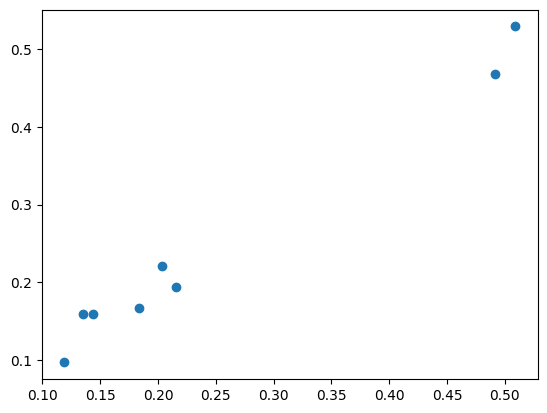

In [10]:
plt.scatter(test.constraints,test.macro_data)

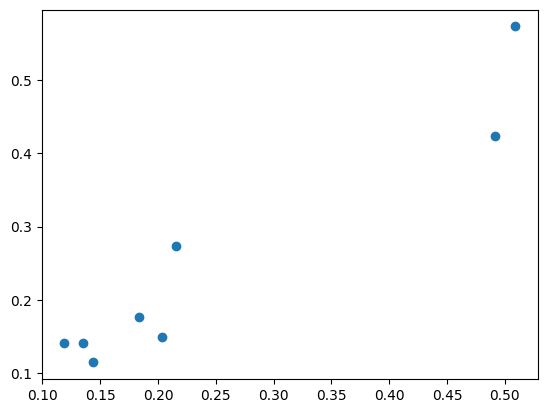

In [11]:
plt.scatter(test.constraints,test.start_macro_data)

In [12]:
# Calculate the absolute difference
absolute_difference = np.abs(test.constraints-test.start_macro_data)

# Calculate the percentage difference
# Using the original values as the reference
random_percentage_difference = (absolute_difference / test.constraints) * 100



In [13]:
# Calculate the absolute difference
absolute_difference = np.abs(test.constraints-test.macro_data)

# Calculate the percentage difference
# Using the original values as the reference
optimised_percentage_difference = (absolute_difference / test.constraints) * 100
print(random_percentage_difference)
print(optimised_percentage_difference)
print(random_percentage_difference-optimised_percentage_difference)

[18.51851852  4.50685826  4.12272291 26.89316414 26.21527778 20.29429798
 13.85498923 12.59310584]
[18.51851852 17.57021555  8.91658677  9.94678674  8.50694444 10.36174126
  4.88155061  3.9320977 ]
[  0.         -13.06335728  -4.79386385  16.9463774   17.70833333
   9.93255671   8.97343862   8.66100814]
